In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, PreTrainedTokenizerFast, DataCollatorForLanguageModeling
import torch
import torch.nn as nn
import sys
import numpy as np
sys.path.append("../VAE_standard")
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE

from matplotlib import pyplot as plt

sys.path.append("..")
import utils

from Bio import SeqIO
from Bio.Seq import Seq

from devinterp.utils import (
    EvaluateFn,
    EvalResults,
)

from BIF_sampler import (
    BIFEstimator,
    estimate_bif
)

from ex2_hamming_vs_influence import get_ex2_data
import pickle
import pandas as pd
import scipy

### For some fixed $n,k$, Define $A_n:=\{$sequences $(x_i,x_j) : BIF(x_i,x_j) \geq$ top $n\%$ of all influences$\}$ and $B_k := \{$sequences $(x_i,x_j) : ||x_i - x_j||_1 \leq k\}$. I want to see if there's anything interesting going on in $A_n \cap B_k$ 
### That is, are there some specific residues where, if a sequence differs in that residue, the influence of that datapoint is massively changed?

### What I do below is I calculate $A_n$, $B_k$ for $n = 90\%$, $k = 1$ and collect sequences $(x_i, x_j) \in A_n \cap B_k$. Then, I calculate the density of influence across all sequence pairs in the dataset by repeatedly permuting the influence matrix to create a null distribution for each residue location among sequences $(x_i, x_j) \in A_n \cap B_k$. What I have then is the following distribution(s):

### At each residue location $r$, consider $N_r := $ the number of sequences in $A_n \cap B_k$ that are distinct at residue r. The sampling procedure above gives me a null distribution for each $N_r$, where the null hypothesis is that influence is randomly assigned. I want to find the residues $r$ such that $N_r$ is significantly larger than it would be under random chance

In [58]:
MAX_TOKEN_LENGTH = 510
BATCH_SIZE=60
BIF_BATCH_SIZE=80
num_masks = 3

TEST_SEQ = 1
MAX_HAM_DIST = 1
MIN_INFLUENCE = 0.9
# TRAIN_CUTOFF = 3000
# TEST_TOKEN = 0

DEVICE = "cuda"

In [59]:
"""
tokenizer: 
input_ids - torch.LongTensor of shape (batch_size, sequence_length)
attention_mask - torch.Tensor of shape (batch_size, sequence_length), Mask values selected in {0,1}, where 0 := masked, 1 := not masked
"""

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15, return_tensors="pt")

model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D").to(DEVICE)

In [60]:
data = get_ex2_data(tokenizer)
aa_drop_na = data["aa_drop_na"]
names_drop_na = data["names_drop_na"]
unique_aa_seqs = data["unique_aa_seqs"]
train_data = data["train_data"]
bif_data = data["bif_data"]

num_obs = len(bif_data)
num_data = len(bif_data)
with open("ex2_computed_influences.pkl", "rb") as file:
    computed_bif_matrix, _ = pickle.load(file)
hamming_dist = torch.sum(((bif_data[None,:,:] - bif_data[:,None,:]) != 0), dim=-1).numpy()

done extracting sequences!
done extracting AAs!


In [61]:
row, col = np.tril_indices(num_data,k=-1)
def inv_cdf(x, bif_matrix=computed_bif_matrix[row,col]):
    """
    given x and computed_bif_matrix, return the inverse -- used to get quantiles

    x (np.array or float): list of values in [0,1] to plug into inverse CDF
    computed_bif_matrix (np.array): array of shape (num_data, num_data), where the i,j entry is the bif of sequence x_i vs. x_j
    """
    
    return np.quantile(bif_matrix, x)

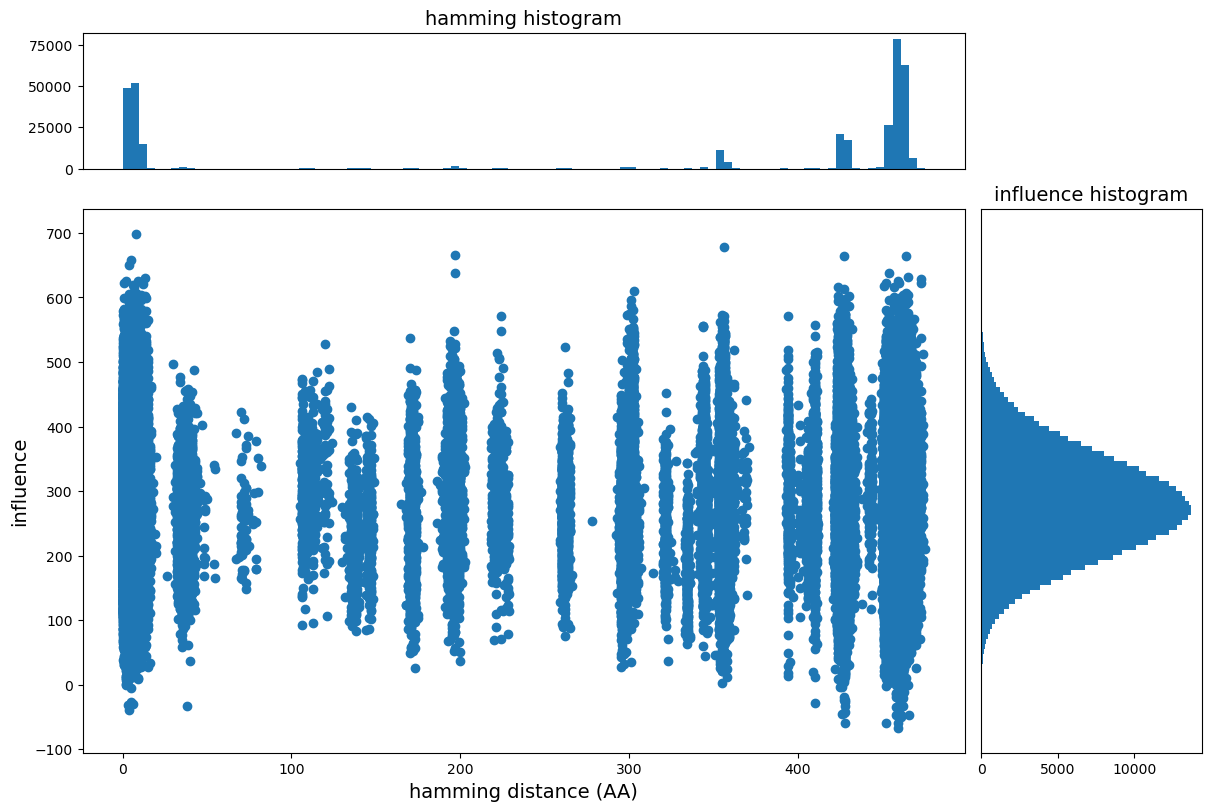

In [63]:
row, col = np.tril_indices(num_data,k=-1)

fsize=14
fig, ax = plt.subplot_mosaic([['hamming', '.'],
                               ['scatter', 'bif']],
                              figsize=(12, 8),
                              width_ratios=(4, 1), height_ratios=(1, 4),
                              layout='constrained')

ax["scatter"].scatter(hamming_dist[row,col], computed_bif_matrix[row,col])
ax["scatter"].set_xlabel("hamming distance (AA)", fontsize=fsize)
ax["scatter"].set_ylabel("influence", fontsize=fsize)

ax["hamming"].hist(hamming_dist[row,col], bins=100)
ax["hamming"].set_xticks([])
ax["hamming"].set_title("hamming histogram", fontsize=fsize)

ax["bif"].hist(computed_bif_matrix[row,col], bins=100, orientation="horizontal")
ax["bif"].set_yticks([])
ax["bif"].set_title("influence histogram", fontsize=fsize)

plt.show()

In [64]:
influence_min = inv_cdf(MIN_INFLUENCE)

row, col = np.tril_indices(num_data,k=-1)
intersection_matrix = np.where((bif_data[None,:,:] - bif_data[:,None,:]) != 0, 1, 0)[row,col,:]
# intersection_matrix = torch.where((bif_data[None,:,:] - bif_data[:,None,:]) != 0, 1, 0)

In [65]:
def construct_null(
    n_runs, 
    seq_length = MAX_TOKEN_LENGTH, 
    num_data = len(bif_data), 
    influence_min=influence_min, 
    max_ham_dist=5,
    bif_matrix=computed_bif_matrix,
    intersection_matrix=intersection_matrix
):
    """
    Compute null_distr for N_r at each residue r (see above)
    
    n_runs (int): number of times to permute influence matrix
    seq_length (int): length of sequence
    num_data (int): number of sequences 
    influence_min (int): nth percentile cutoff for influence, i.e. n for A_n (see above)
    max_ham_dist (int): max hamming distance cutoff, i.e. k for B_k (see above)
    intersection matrix (np.array): array of shape (num_data, num_data, seq_length) s.t. the i,j,k entry is 1 iff sequence i and sequence j overlap at residue k, and 0 otherwise

    returns:
    null_distr (np.array): array of shape (n_runs, seq_length) s.t. the r-th column i.e. null_distr[:,r] is the null distribution of residue r
    """
    
    null_distr = np.zeros((n_runs, seq_length))
    row, col = np.tril_indices(num_data,k=-1)
    bif_matrix = bif_matrix[row,col]

    #apply additional hamming filter so that only similar sequence influences are permuted
    hamming_filter = (hamming_dist <= max_ham_dist)[row,col]
    bif_matrix = bif_matrix[hamming_filter]
    intersection_matrix = intersection_matrix[hamming_filter]

    # sample values to get null distr.
    for i in range(n_runs):
        if i % 100 == 0:
            print(".",end="")

        # randomly permute influence
        permuted_influence = np.random.permutation(bif_matrix)
        
        rand_bif_filtered_matrix = permuted_influence >= influence_min

        # since we've already filtered by hamming, I only have to consider the sequences that also have high influence
        int_mat = np.sum(intersection_matrix[rand_bif_filtered_matrix], axis=0)
        null_distr[i,:] = int_mat

    return null_distr

In [66]:
null_distr = construct_null(5000, max_ham_dist=MAX_HAM_DIST, influence_min=influence_min)

..................................................

### Procedure for obtaining p-values:
### (1) &ensp; Compute null distr. by repeatedly permuting influence matrix and computing $N_r$ via $A_n \cap  B_k$ using the permuted influence
### (2) &ensp; For each residue $N_r \sim$ $Null$, I compute $P(N_r \geq N_r^{(true)})$, where $N_r^{(true)}$ is the true count of $A_n \cap B_k$ at residue r

In [67]:
bif_filtered_matrix = computed_bif_matrix >= influence_min
intersection = np.logical_and(hamming_dist <= MAX_HAM_DIST, bif_filtered_matrix)[row,col]
int_mat_true = np.sum(intersection_matrix[intersection], axis=0)

p_vals = (null_distr >= int_mat_true[None,:]).mean(axis=0)

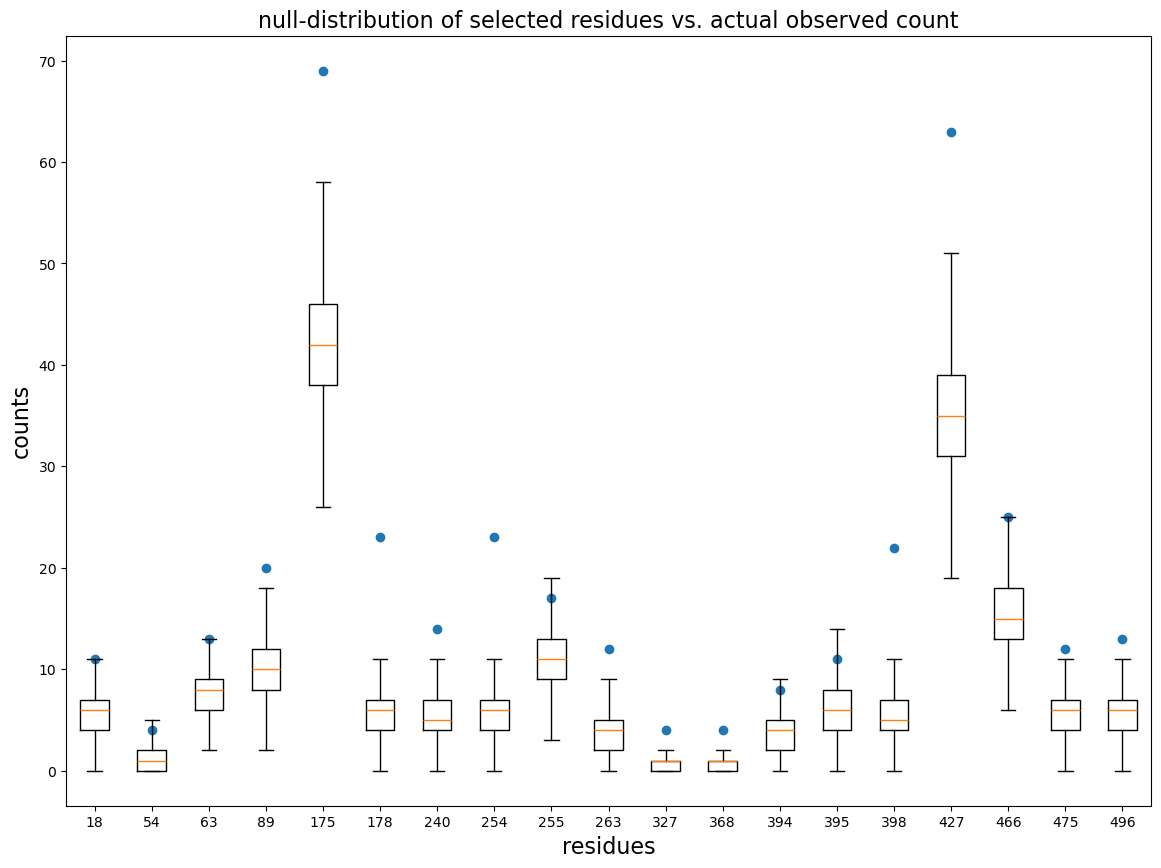

In [68]:
P_VAL_THRESHOLD = 0.05

sig_p_vals_index = np.arange(MAX_TOKEN_LENGTH)[p_vals <= P_VAL_THRESHOLD]
fig, ax = plt.subplots(1,1,figsize=(14,10))
# ax.scatter(np.arange(MAX_TOKEN_LENGTH)[sig_p_vals_index], p_vals[sig_p_vals_index])
# ax.boxplot([null_distr[:,0], null_distr[:,1]], vert=True)
ax.boxplot([null_distr[:,x] for x in sig_p_vals_index], vert=True, showfliers=False)
ax.set_xticklabels(sig_p_vals_index)
ax.scatter(np.arange(sig_p_vals_index.shape[0]) + 1, int_mat_true[sig_p_vals_index])
ax.set_xlabel("residues", fontsize=16)
ax.set_ylabel("counts", fontsize=16)
plt.title("null-distribution of selected residues vs. actual observed count", fontsize=16)
plt.show()

In [57]:
# tot_data_pair_prop = np.sum(int_mat_true) / (len(bif_data) * len(bif_data)) * 100 

# disp_p_vals = p_vals.reshape(17,30)
# fig,ax = plt.subplots(1,1,figsize=(14,10))
# im = ax.matshow(disp_p_vals <= P_VAL_THRESHOLD, cmap='bone')
# plt.title("p-values per residue for affecting influence", fontsize=20)
# ax.set_xticks([])
# ax.set_xlabel("*|A_n intersect B_k| makes up %.2f%% of total pairs, i.e. %d significant residues (%d pairs)"%(tot_data_pair_prop, len(int_mat_true[p_vals < 0.02]), np.sum(int_mat_true[p_vals < 0.02])), fontsize=14)
# ax.set_yticks(np.arange(17))
# ax.set_yticklabels(["residues %d - %d"%(i*30, (i+1)*30 - 1) for i in range(17)])
# plt.colorbar(im)
# plt.show()